--- Classification Metrics (From Scratch) ---
Confusion Matrix:
 [[59  9]
 [18 64]]
---------------------------------------------
Accuracy:  0.8200
Precision: 0.8767
Recall:    0.7805
F1-Score:  0.8258
AUC Score: 0.9039


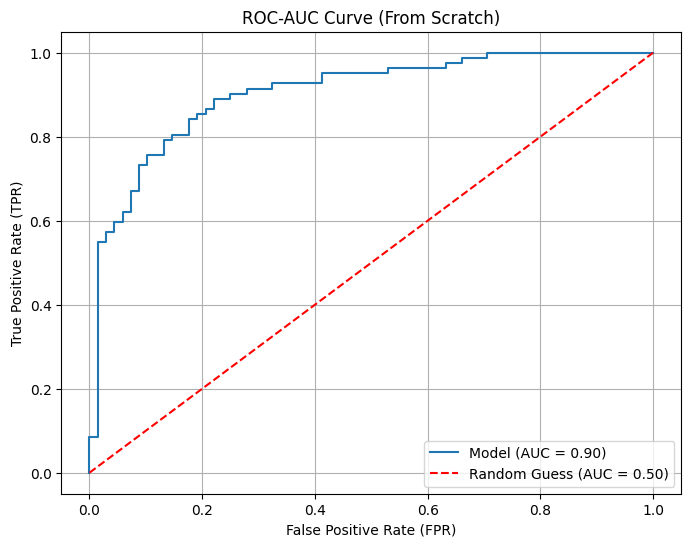

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------
# CLASS 1: OUR FROM-SCRATCH STANDARD SCALER
# -----------------------------------------------------------------
class MyStandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        """Calculates and stores the mean and std dev of each feature."""
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        # Avoid division by zero for constant features
        self.std_[self.std_ == 0] = 1.0

    def transform(self, X):
        """Applies the standardization using the stored mean and std."""
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Must call fit() before transform()")
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        """A helper function to do both fit and transform."""
        self.fit(X)
        return self.transform(X)

# -----------------------------------------------------------------
# CLASS 2: OUR FROM-SCRATCH LOGISTIC REGRESSION
# -----------------------------------------------------------------
class MyLogisticRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        """The sigmoid activation function"""
        # Added clipping to prevent overflow for large negative z
        z_clipped = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z_clipped))

    def fit(self, X, y):
        """Trains the model using gradient descent."""
        n_samples, n_features = X.shape
        
        # 1. Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # 2. Gradient Descent loop
        for _ in range(self.n_iters):
            # Calculate the linear model (z = w*x + b)
            z = np.dot(X, self.weights) + self.bias
            
            # Get the predicted probabilities (hypothesis)
            y_pred_proba = self._sigmoid(z)
            
            # 3. Calculate gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_pred_proba - y))
            db = (1 / n_samples) * np.sum(y_pred_proba - y)
            
            # 4. Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        """Returns the raw probabilities (between 0 and 1)"""
        z = np.dot(X, self.weights) + self.bias
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        """Returns the final class labels (0 or 1)"""
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

# -----------------------------------------------------------------
# CLASS 3: OUR FROM-SCRATCH METRICS CLASS (WITH ROC-AUC)
# -----------------------------------------------------------------
class MyClassificationMetrics:
    def __init__(self, y_true, y_pred, y_probs):
        """
        Initializes the metrics class.
        
        y_true: (n_samples,) numpy array of true labels (0 or 1)
        y_pred: (n_samples,) numpy array of predicted labels (0 or 1)
        y_probs: (n_samples,) numpy array of predicted probabilities (0 to 1)
        """
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_probs = y_probs
        
        # --- Calculate components for Accuracy, Precision, etc. ---
        self.tp = np.sum((y_true == 1) & (y_pred == 1))
        self.tn = np.sum((y_true == 0) & (y_pred == 0))
        self.fp = np.sum((y_true == 0) & (y_pred == 1))
        self.fn = np.sum((y_true == 1) & (y_pred == 0))
        
        # --- Attributes for ROC-AUC ---
        self.fpr_list = None
        self.tpr_list = None
        self.auc_score = None
        
        # --- Automatically calculate ROC-AUC on init ---
        self._calculate_roc_auc_logic()

    def confusion_matrix(self):
        """Returns the confusion matrix as a 2x2 numpy array."""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def accuracy(self):
        """Calculates Accuracy: (TP + TN) / (Total)"""
        total = self.tp + self.tn + self.fp + self.fn
        return 0.0 if total == 0 else (self.tp + self.tn) / total

    def precision(self):
        """Calculates Precision: TP / (TP + FP)"""
        denominator = self.tp + self.fp
        return 0.0 if denominator == 0 else self.tp / denominator

    def recall(self):
        """Calculates Recall (Sensitivity): TP / (TP + FN)"""
        denominator = self.tp + self.fn
        return 0.0 if denominator == 0 else self.tp / denominator

    def f1_score(self):
        """Calculates F1-Score: 2 * (Precision * Recall) / (Precision + Recall)"""
        denominator = (2 * self.tp) + self.fp + self.fn
        return 0.0 if denominator == 0 else (2 * self.tp) / denominator

    def _calculate_roc_auc_logic(self):
        """Internal method to calculate ROC curve points and AUC score."""
        
        # 1. Get all unique probability values and sort them
        thresholds = np.unique(self.y_probs)
        thresholds = np.sort(thresholds)[::-1] # Descending
        thresholds_with_start = np.concatenate([[1.00001], thresholds])
        
        tpr_list = []
        fpr_list = []
        
        num_positives = np.sum(self.y_true == 1)
        num_negatives = np.sum(self.y_true == 0)

        if num_positives == 0 or num_negatives == 0:
            self.fpr_list = [0]
            self.tpr_list = [0]
            self.auc_score = 0.5
            return

        # 2. Iterate through all thresholds
        for thresh in thresholds_with_start:
            y_pred_thresh = (self.y_probs >= thresh).astype(int)
            
            tp = np.sum((self.y_true == 1) & (y_pred_thresh == 1))
            fp = np.sum((self.y_true == 0) & (y_pred_thresh == 1))
            
            tpr = tp / num_positives  # TPR = TP / (TP + FN)
            fpr = fp / num_negatives  # FPR = FP / (FP + TN)
            
            tpr_list.append(tpr)
            fpr_list.append(fpr)
            
        self.fpr_list = fpr_list
        self.tpr_list = tpr_list
        
        # 3. Calculate AUC using the trapezoidal rule
        auc = 0.0
        for i in range(1, len(self.fpr_list)):
            width = self.fpr_list[i] - self.fpr_list[i-1]
            height_avg = (self.tpr_list[i] + self.tpr_list[i-1]) / 2
            auc += width * height_avg
            
        self.auc_score = auc

    def get_auc_score(self):
        """Returns the calculated AUC score."""
        return self.auc_score

    def plot_roc_curve(self):
        """Plots the calculated ROC curve using matplotlib."""
        if self.fpr_list is None:
            print("ROC data not calculated.")
            return
        
        plt.figure(figsize=(8, 6))
        plt.plot(self.fpr_list, self.tpr_list, label=f'Model (AUC = {self.auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'r--', label='Random Guess (AUC = 0.50)')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('ROC-AUC Curve (From Scratch)')
        plt.legend()
        plt.grid(True)
        plt.show()

    def print_all_metrics(self):
        """Helper function to print a clean summary."""
        print("--- Classification Metrics (From Scratch) ---")
        print(f"Confusion Matrix:\n {self.confusion_matrix()}")
        print("---------------------------------------------")
        print(f"Accuracy:  {self.accuracy():.4f}")
        print(f"Precision: {self.precision():.4f}")
        print(f"Recall:    {self.recall():.4f}")
        print(f"F1-Score:  {self.f1_score():.4f}")
        print(f"AUC Score: {self.get_auc_score():.4f}")

# # -----------------------------------------------------------------
# # --- EXAMPLE USAGE ---
# # -----------------------------------------------------------------

# # 1. Create a dataset
# X, y = make_classification(n_samples=500, n_features=10, 
#                            n_informative=5, n_redundant=2, 
#                            random_state=42)

# # 2. Split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # 3. Standardize
# scaler = MyStandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # 4. Train
# model = MyLogisticRegression(learning_rate=0.1, n_iters=1000)
# model.fit(X_train_scaled, y_train)

# # 5. Get both Predictions (0/1) and Probabilities (0-1)
# y_pred = model.predict(X_test_scaled)
# y_probs = model.predict_proba(X_test_scaled)

# # 6. Use our metrics class
# # Pass in the true labels, binary predictions, AND probabilities
# metrics = MyClassificationMetrics(y_test, y_pred, y_probs)

# # 7. Print all results
# metrics.print_all_metrics()

# # 8. Plot the ROC curve
# metrics.plot_roc_curve()